In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number - filename
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 1

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 200

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-11 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = False
AUGMENT_PHASES_RANGE = (-3,3)
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10


Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-02-25 11:16:38,256 INFO -------------------- Start --------------------
2021-02-25 11:16:38,256 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-25 11:16:38,257 INFO Log file: ./logs/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0.log
2021-02-25 11:16:38,257 INFO Log level for console: INFO
2021-02-25 11:16:38,258 INFO Is built with tensorflow: True
2021-02-25 11:16:38,324 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_11_16', 'MODEL_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_11_16/model', 'TENSORBOARD_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_11_16/tensorboard_logs', 'CONFIG_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_11_16/config', 'HISTORY_PATH': 'exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_11_16/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv', 'DF_META': '/m

2021-02-25 11:16:38,988 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6986617706692620095
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9774292278263135915
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 131399263737586435
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17999806783004097331
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23177397504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4633007388217415254
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23561682304
locality {
  bus_id:

In [2]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-02-25 11:16:39,010 INFO no files found, try to load with acdc file pattern
2021-02-25 11:16:39,017 INFO Found 0 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-02-25 11:16:39,017 INFO Patients train: 209
2021-02-25 11:16:39,018 INFO Selected 0 of 0 files with 209 of 279 patients for training fold 1
2021-02-25 11:16:39,018 INFO SAX train CMR: 0, SAX train masks: 0
2021-02-25 11:16:39,019 INFO SAX val CMR: 0, SAX val masks: 0


In [3]:
# check if we find each patient in the corresponding dataframe
import re
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-02-25 11:16:39,051 INFO Check if we find the patient ID and phase mapping for all: 0 files.
2021-02-25 11:16:39,052 INFO Done!


In [4]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [5]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

IndexError: list index out of range

In [14]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:
    
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gtlen = int(np.sum((gt_len_msk[im,0,:,0])))
        logging.info('GT length: {}'.format(selected_gtlen))

        logging.debug('pad: \n{}'.format(selected_output))
        
        f, axs = plt.subplots(1,2,figsize=(5,5))
        i = 0
        temp_y = selected_output
        ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0)
        axs[0].title.set_text('y')
        axs[0].set_yticks(ind_gt, minor=False)
        axs[0].set_xticks([0,1,2,3,4], minor=False)
        axs[0].set_xticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto')
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
    
    if show_input_vol:list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))

        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=13, description='batch', max=26), IntSlider(value=3, description='im', m…

In [15]:
# test if all batches are processable
"""for b in range(len(validation_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)"""

'for b in range(len(validation_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_=True)'

In [16]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

Shape after the temporal encoder
(None, 36, 8, 8, 8, 256)
Shape after GAP
(None, 36, 256)
Shape after Bi-LSTM layer
(None, 36, 256)
Shape after final conv layer
(None, 36, 5)


In [18]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
# model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack_2 (TensorFlowOpLayer)        [(None, 36, 64, 64, 1), (None, 3 0                 input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder_3 (ConvEncoder)                     ((None, 36, 8, 

In [19]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-02-25 10:26:20,310 INFO feed 4 Tensorboard is ready


Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 1.3454 - mse_wrapper: 0.0744 - ca_wrapper: 0.4764 - meandiff: 9.8990

2021-02-25 10:27:19,337 INFO (4, 2, 36, 5)
2021-02-25 10:27:19,862 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.34540, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 1.3454 - mse_wrapper: 0.0744 - ca_wrapper: 0.4764 - meandiff: 9.8990 - val_loss: 1.3330 - val_mse_wrapper: 0.0741 - val_ca_wrapper: 0.5009 - val_meandiff: 8.2812 - lr: 1.0000e-04
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 1.1188 - mse_wrapper: 0.0539 - ca_wrapper: 0.6334 - meandiff: 6.9183

2021-02-25 10:27:49,514 INFO (4, 2, 36, 5)
2021-02-25 10:27:50,048 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 1.34540 to 1.11880, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 1.1188 - mse_wrapper: 0.0539 - ca_wrapper: 0.6334 - meandiff: 6.9183 - val_loss: 1.4963 - val_mse_wrapper: 0.0907 - val_ca_wrapper: 0.4349 - val_meandiff: 8.5312 - lr: 1.0000e-04
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 0.9971 - mse_wrapper: 0.0430 - ca_wrapper: 0.7083 - meandiff: 6.0048

2021-02-25 10:28:19,942 INFO (4, 2, 36, 5)
2021-02-25 10:28:20,457 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 1.11880 to 0.99713, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 28s 1s/step - loss: 0.9971 - mse_wrapper: 0.0430 - ca_wrapper: 0.7083 - meandiff: 6.0048 - val_loss: 1.2876 - val_mse_wrapper: 0.0685 - val_ca_wrapper: 0.5938 - val_meandiff: 8.7812 - lr: 1.0000e-04
Epoch 4/200
26/26 [==============================] - ETA: 0s - loss: 0.9725 - mse_wrapper: 0.0408 - ca_wrapper: 0.7312 - meandiff: 5.7212

2021-02-25 10:28:49,989 INFO (4, 2, 36, 5)
2021-02-25 10:28:50,526 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 0.99713 to 0.97247, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 28s 1s/step - loss: 0.9725 - mse_wrapper: 0.0408 - ca_wrapper: 0.7312 - meandiff: 5.7212 - val_loss: 1.0434 - val_mse_wrapper: 0.0476 - val_ca_wrapper: 0.6693 - val_meandiff: 5.8438 - lr: 1.0000e-04
Epoch 5/200
26/26 [==============================] - ETA: 0s - loss: 0.9142 - mse_wrapper: 0.0354 - ca_wrapper: 0.7560 - meandiff: 5.5481
Epoch 00005: loss improved from 0.97247 to 0.91415, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 27s 1s/step - loss: 0.9142 - mse_wrapper: 0.0354 - ca_wrapper: 0.7560 - meandiff: 5.5481 - val_loss: 1.0110 - val_mse_wrapper: 0.0443 - val_ca_wrapper: 0.6845 - val_meandiff: 5.5312 - lr: 1.0000e-04
Epoch

2021-02-25 10:29:49,036 INFO (4, 2, 36, 5)
2021-02-25 10:29:49,808 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 0.91415 to 0.89310, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 0.8931 - mse_wrapper: 0.0334 - ca_wrapper: 0.7671 - meandiff: 5.4231 - val_loss: 1.0114 - val_mse_wrapper: 0.0441 - val_ca_wrapper: 0.6771 - val_meandiff: 5.7188 - lr: 1.0000e-04
Epoch 7/200
26/26 [==============================] - ETA: 0s - loss: 0.8764 - mse_wrapper: 0.0317 - ca_wrapper: 0.7734 - meandiff: 5.3173
Epoch 00007: loss improved from 0.89310 to 0.87638, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 28s 1s/step - loss: 0.8764 - mse_wrapper: 0.0317 - ca_wrapper: 0.7734 - meandiff: 5.3173 - val_loss: 1.0162 - val_mse_wrapper: 0.0444 - val_ca_wrapper: 0.6780 - val_meandiff: 6.0000 - lr: 1.0000e-04
Epoch

2021-02-25 10:30:50,616 INFO (4, 2, 36, 5)
2021-02-25 10:30:51,160 INFO (4, 2, 36, 5)



Epoch 00008: loss did not improve from 0.87638
26/26 [==============================] - 30s 1s/step - loss: 0.9285 - mse_wrapper: 0.0366 - ca_wrapper: 0.7481 - meandiff: 5.4183 - val_loss: 1.0045 - val_mse_wrapper: 0.0419 - val_ca_wrapper: 0.7001 - val_meandiff: 5.6562 - lr: 1.0000e-04
Epoch 9/200
26/26 [==============================] - ETA: 0s - loss: 0.8775 - mse_wrapper: 0.0315 - ca_wrapper: 0.7771 - meandiff: 5.4567
Epoch 00009: loss did not improve from 0.87638
26/26 [==============================] - 29s 1s/step - loss: 0.8775 - mse_wrapper: 0.0315 - ca_wrapper: 0.7771 - meandiff: 5.4567 - val_loss: 1.0086 - val_mse_wrapper: 0.0420 - val_ca_wrapper: 0.7070 - val_meandiff: 5.9062 - lr: 1.0000e-04
Epoch 10/200
26/26 [==============================] - ETA: 0s - loss: 0.8683 - mse_wrapper: 0.0309 - ca_wrapper: 0.7814 - meandiff: 5.1779

2021-02-25 10:31:53,335 INFO (4, 2, 36, 5)
2021-02-25 10:31:53,910 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 0.87638 to 0.86826, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8683 - mse_wrapper: 0.0309 - ca_wrapper: 0.7814 - meandiff: 5.1779 - val_loss: 1.0028 - val_mse_wrapper: 0.0412 - val_ca_wrapper: 0.6957 - val_meandiff: 6.0156 - lr: 1.0000e-04
Epoch 11/200
26/26 [==============================] - ETA: 0s - loss: 0.8481 - mse_wrapper: 0.0287 - ca_wrapper: 0.7954 - meandiff: 4.9567
Epoch 00011: loss improved from 0.86826 to 0.84814, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8481 - mse_wrapper: 0.0287 - ca_wrapper: 0.7954 - meandiff: 4.9567 - val_loss: 0.9447 - val_mse_wrapper: 0.0368 - val_ca_wrapper: 0.7335 - val_meandiff: 5.3906 - lr: 1.0000e-04
Epoc

2021-02-25 10:32:57,574 INFO (4, 2, 36, 5)
2021-02-25 10:32:58,112 INFO (4, 2, 36, 5)



Epoch 00012: loss improved from 0.84814 to 0.83551, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8355 - mse_wrapper: 0.0273 - ca_wrapper: 0.8041 - meandiff: 4.8413 - val_loss: 1.0513 - val_mse_wrapper: 0.0440 - val_ca_wrapper: 0.7014 - val_meandiff: 5.5312 - lr: 1.0000e-04
Epoch 13/200
26/26 [==============================] - ETA: 0s - loss: 0.8311 - mse_wrapper: 0.0269 - ca_wrapper: 0.8064 - meandiff: 4.8173
Epoch 00013: loss improved from 0.83551 to 0.83106, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8311 - mse_wrapper: 0.0269 - ca_wrapper: 0.8064 - meandiff: 4.8173 - val_loss: 1.1844 - val_mse_wrapper: 0.0545 - val_ca_wrapper: 0.6406 - val_meandiff: 6.4531 - lr: 1.0000e-04
Epoc

2021-02-25 10:34:01,455 INFO (4, 2, 36, 5)
2021-02-25 10:34:01,955 INFO (4, 2, 36, 5)



Epoch 00014: loss did not improve from 0.83106
26/26 [==============================] - 30s 1s/step - loss: 0.8359 - mse_wrapper: 0.0275 - ca_wrapper: 0.7957 - meandiff: 4.7692 - val_loss: 1.0923 - val_mse_wrapper: 0.0489 - val_ca_wrapper: 0.6697 - val_meandiff: 6.0312 - lr: 1.0000e-04
Epoch 15/200
26/26 [==============================] - ETA: 0s - loss: 0.8298 - mse_wrapper: 0.0269 - ca_wrapper: 0.8042 - meandiff: 4.6923
Epoch 00015: loss improved from 0.83106 to 0.82985, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8298 - mse_wrapper: 0.0269 - ca_wrapper: 0.8042 - meandiff: 4.6923 - val_loss: 1.0170 - val_mse_wrapper: 0.0409 - val_ca_wrapper: 0.7244 - val_meandiff: 5.4531 - lr: 1.0000e-04
Epoch 16/200
26/26 [==============================] - ETA: 0s - loss: 0.8182 - mse_wrapper: 0.0255 - ca_wrapper: 0.8132 - meandiff: 4.6250

2021-02-25 10:35:05,849 INFO (4, 2, 36, 5)
2021-02-25 10:35:06,366 INFO (4, 2, 36, 5)



Epoch 00016: loss improved from 0.82985 to 0.81822, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.8182 - mse_wrapper: 0.0255 - ca_wrapper: 0.8132 - meandiff: 4.6250 - val_loss: 1.1981 - val_mse_wrapper: 0.0546 - val_ca_wrapper: 0.6528 - val_meandiff: 6.4375 - lr: 1.0000e-04
Epoch 17/200
26/26 [==============================] - ETA: 0s - loss: 0.8173 - mse_wrapper: 0.0253 - ca_wrapper: 0.8142 - meandiff: 4.6202
Epoch 00017: loss improved from 0.81822 to 0.81729, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8173 - mse_wrapper: 0.0253 - ca_wrapper: 0.8142 - meandiff: 4.6202 - val_loss: 0.9984 - val_mse_wrapper: 0.0402 - val_ca_wrapper: 0.7057 - val_meandiff: 5.3906 - lr: 1.0000e-04
Epoc

2021-02-25 10:36:09,945 INFO (4, 2, 36, 5)
2021-02-25 10:36:10,455 INFO (4, 2, 36, 5)



Epoch 00018: loss improved from 0.81729 to 0.81535, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8153 - mse_wrapper: 0.0252 - ca_wrapper: 0.8125 - meandiff: 4.4471 - val_loss: 1.1756 - val_mse_wrapper: 0.0503 - val_ca_wrapper: 0.6931 - val_meandiff: 5.5469 - lr: 1.0000e-04
Epoch 19/200
26/26 [==============================] - ETA: 0s - loss: 0.8101 - mse_wrapper: 0.0248 - ca_wrapper: 0.8158 - meandiff: 4.4615
Epoch 00019: loss improved from 0.81535 to 0.81007, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8101 - mse_wrapper: 0.0248 - ca_wrapper: 0.8158 - meandiff: 4.4615 - val_loss: 1.1454 - val_mse_wrapper: 0.0505 - val_ca_wrapper: 0.6710 - val_meandiff: 5.8594 - lr: 1.0000e-04
Epoc

2021-02-25 10:37:14,150 INFO (4, 2, 36, 5)
2021-02-25 10:37:14,689 INFO (4, 2, 36, 5)



Epoch 00020: loss improved from 0.81007 to 0.80772, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8077 - mse_wrapper: 0.0247 - ca_wrapper: 0.8140 - meandiff: 4.7212 - val_loss: 1.2156 - val_mse_wrapper: 0.0538 - val_ca_wrapper: 0.6567 - val_meandiff: 6.0625 - lr: 1.0000e-04
Epoch 21/200
26/26 [==============================] - ETA: 0s - loss: 0.8054 - mse_wrapper: 0.0241 - ca_wrapper: 0.8212 - meandiff: 4.4808
Epoch 00021: loss improved from 0.80772 to 0.80542, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.8054 - mse_wrapper: 0.0241 - ca_wrapper: 0.8212 - meandiff: 4.4808 - val_loss: 1.2502 - val_mse_wrapper: 0.0549 - val_ca_wrapper: 0.6584 - val_meandiff: 6.1562 - lr: 1.0000e-04
Epoc

2021-02-25 10:38:17,787 INFO (4, 2, 36, 5)
2021-02-25 10:38:18,643 INFO (4, 2, 36, 5)



Epoch 00022: loss improved from 0.80542 to 0.80220, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.8022 - mse_wrapper: 0.0238 - ca_wrapper: 0.8174 - meandiff: 4.3173 - val_loss: 1.0605 - val_mse_wrapper: 0.0419 - val_ca_wrapper: 0.7209 - val_meandiff: 5.4219 - lr: 1.0000e-04
Epoch 23/200
26/26 [==============================] - ETA: 0s - loss: 0.8104 - mse_wrapper: 0.0246 - ca_wrapper: 0.8162 - meandiff: 4.3942
Epoch 00023: loss did not improve from 0.80220
26/26 [==============================] - 29s 1s/step - loss: 0.8104 - mse_wrapper: 0.0246 - ca_wrapper: 0.8162 - meandiff: 4.3942 - val_loss: 1.0181 - val_mse_wrapper: 0.0404 - val_ca_wrapper: 0.7244 - val_meandiff: 5.0312 - lr: 1.0000e-04
Epoch 24/200
26/26 [==============================] - ETA: 0s - loss: 0.7973 - mse_wrapper: 0.0234 - ca_wrapper: 0.8192 - meandiff: 4.3173

2021-02-25 10:39:21,474 INFO (4, 2, 36, 5)
2021-02-25 10:39:21,977 INFO (4, 2, 36, 5)



Epoch 00024: loss improved from 0.80220 to 0.79726, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7973 - mse_wrapper: 0.0234 - ca_wrapper: 0.8192 - meandiff: 4.3173 - val_loss: 1.2505 - val_mse_wrapper: 0.0559 - val_ca_wrapper: 0.6476 - val_meandiff: 6.0781 - lr: 1.0000e-04
Epoch 25/200
26/26 [==============================] - ETA: 0s - loss: 0.8024 - mse_wrapper: 0.0236 - ca_wrapper: 0.8201 - meandiff: 4.2981
Epoch 00025: loss did not improve from 0.79726
26/26 [==============================] - 29s 1s/step - loss: 0.8024 - mse_wrapper: 0.0236 - ca_wrapper: 0.8201 - meandiff: 4.2981 - val_loss: 1.0489 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7044 - val_meandiff: 5.6562 - lr: 1.0000e-04
Epoch 26/200
26/26 [==============================] - ETA: 0s - loss: 0.8047 - mse_wrapper: 0.0242 - ca_wrapper: 0.8134 - meandiff: 4.5721

2021-02-25 10:40:24,172 INFO (4, 2, 36, 5)
2021-02-25 10:40:24,735 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 0.79726
26/26 [==============================] - 30s 1s/step - loss: 0.8047 - mse_wrapper: 0.0242 - ca_wrapper: 0.8134 - meandiff: 4.5721 - val_loss: 1.0977 - val_mse_wrapper: 0.0474 - val_ca_wrapper: 0.6780 - val_meandiff: 5.8594 - lr: 1.0000e-04
Epoch 27/200
26/26 [==============================] - ETA: 0s - loss: 0.7985 - mse_wrapper: 0.0235 - ca_wrapper: 0.8210 - meandiff: 4.4423
Epoch 00027: loss did not improve from 0.79726
26/26 [==============================] - 30s 1s/step - loss: 0.7985 - mse_wrapper: 0.0235 - ca_wrapper: 0.8210 - meandiff: 4.4423 - val_loss: 1.0274 - val_mse_wrapper: 0.0406 - val_ca_wrapper: 0.7066 - val_meandiff: 4.9062 - lr: 1.0000e-04
Epoch 28/200
26/26 [==============================] - ETA: 0s - loss: 0.7960 - mse_wrapper: 0.0232 - ca_wrapper: 0.8241 - meandiff: 4.3077

2021-02-25 10:41:28,189 INFO (4, 2, 36, 5)
2021-02-25 10:41:28,747 INFO (4, 2, 36, 5)



Epoch 00028: loss improved from 0.79726 to 0.79600, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7960 - mse_wrapper: 0.0232 - ca_wrapper: 0.8241 - meandiff: 4.3077 - val_loss: 0.9800 - val_mse_wrapper: 0.0364 - val_ca_wrapper: 0.7461 - val_meandiff: 4.8750 - lr: 1.0000e-04
Epoch 29/200
26/26 [==============================] - ETA: 0s - loss: 0.7926 - mse_wrapper: 0.0229 - ca_wrapper: 0.8241 - meandiff: 4.2933
Epoch 00029: loss improved from 0.79600 to 0.79262, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7926 - mse_wrapper: 0.0229 - ca_wrapper: 0.8241 - meandiff: 4.2933 - val_loss: 1.0860 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7222 - val_meandiff: 5.0312 - lr: 1.0000e-04
Epoc

2021-02-25 10:42:31,681 INFO (4, 2, 36, 5)
2021-02-25 10:42:32,226 INFO (4, 2, 36, 5)



Epoch 00030: loss did not improve from 0.79262
26/26 [==============================] - 30s 1s/step - loss: 0.7927 - mse_wrapper: 0.0227 - ca_wrapper: 0.8264 - meandiff: 4.1394 - val_loss: 1.2236 - val_mse_wrapper: 0.0555 - val_ca_wrapper: 0.6536 - val_meandiff: 6.3125 - lr: 1.0000e-04
Epoch 31/200
26/26 [==============================] - ETA: 0s - loss: 0.7944 - mse_wrapper: 0.0232 - ca_wrapper: 0.8247 - meandiff: 4.3654
Epoch 00031: loss did not improve from 0.79262
26/26 [==============================] - 30s 1s/step - loss: 0.7944 - mse_wrapper: 0.0232 - ca_wrapper: 0.8247 - meandiff: 4.3654 - val_loss: 1.0407 - val_mse_wrapper: 0.0408 - val_ca_wrapper: 0.7244 - val_meandiff: 5.5625 - lr: 1.0000e-04
Epoch 32/200
26/26 [==============================] - ETA: 0s - loss: 0.7796 - mse_wrapper: 0.0215 - ca_wrapper: 0.8325 - meandiff: 4.1442

2021-02-25 10:43:35,508 INFO (4, 2, 36, 5)
2021-02-25 10:43:36,014 INFO (4, 2, 36, 5)



Epoch 00032: loss improved from 0.79262 to 0.77962, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7796 - mse_wrapper: 0.0215 - ca_wrapper: 0.8325 - meandiff: 4.1442 - val_loss: 1.1287 - val_mse_wrapper: 0.0464 - val_ca_wrapper: 0.6966 - val_meandiff: 5.4062 - lr: 1.0000e-04
Epoch 33/200
26/26 [==============================] - ETA: 0s - loss: 0.7903 - mse_wrapper: 0.0224 - ca_wrapper: 0.8276 - meandiff: 4.1490
Epoch 00033: loss did not improve from 0.77962
26/26 [==============================] - 29s 1s/step - loss: 0.7903 - mse_wrapper: 0.0224 - ca_wrapper: 0.8276 - meandiff: 4.1490 - val_loss: 1.1631 - val_mse_wrapper: 0.0479 - val_ca_wrapper: 0.6953 - val_meandiff: 5.7188 - lr: 1.0000e-04
Epoch 34/200
26/26 [==============================] - ETA: 0s - loss: 0.7810 - mse_wrapper: 0.0217 - ca_wrapper: 0.8311 - meandiff: 4.1442

2021-02-25 10:44:38,707 INFO (4, 2, 36, 5)
2021-02-25 10:44:39,250 INFO (4, 2, 36, 5)



Epoch 00034: loss did not improve from 0.77962
26/26 [==============================] - 31s 1s/step - loss: 0.7810 - mse_wrapper: 0.0217 - ca_wrapper: 0.8311 - meandiff: 4.1442 - val_loss: 1.1493 - val_mse_wrapper: 0.0459 - val_ca_wrapper: 0.7253 - val_meandiff: 5.5781 - lr: 1.0000e-04
Epoch 35/200
26/26 [==============================] - ETA: 0s - loss: 0.7884 - mse_wrapper: 0.0224 - ca_wrapper: 0.8281 - meandiff: 4.2740
Epoch 00035: loss did not improve from 0.77962
26/26 [==============================] - 29s 1s/step - loss: 0.7884 - mse_wrapper: 0.0224 - ca_wrapper: 0.8281 - meandiff: 4.2740 - val_loss: 1.1194 - val_mse_wrapper: 0.0444 - val_ca_wrapper: 0.7166 - val_meandiff: 5.2812 - lr: 1.0000e-04
Epoch 36/200
26/26 [==============================] - ETA: 0s - loss: 0.7841 - mse_wrapper: 0.0219 - ca_wrapper: 0.8303 - meandiff: 4.1154

2021-02-25 10:45:41,855 INFO (4, 2, 36, 5)
2021-02-25 10:45:42,403 INFO (4, 2, 36, 5)



Epoch 00036: loss did not improve from 0.77962
26/26 [==============================] - 30s 1s/step - loss: 0.7841 - mse_wrapper: 0.0219 - ca_wrapper: 0.8303 - meandiff: 4.1154 - val_loss: 1.0328 - val_mse_wrapper: 0.0407 - val_ca_wrapper: 0.7253 - val_meandiff: 5.1719 - lr: 1.0000e-04
Epoch 37/200
26/26 [==============================] - ETA: 0s - loss: 0.7822 - mse_wrapper: 0.0217 - ca_wrapper: 0.8327 - meandiff: 4.0240
Epoch 00037: loss did not improve from 0.77962

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
26/26 [==============================] - 30s 1s/step - loss: 0.7822 - mse_wrapper: 0.0217 - ca_wrapper: 0.8327 - meandiff: 4.0240 - val_loss: 1.1248 - val_mse_wrapper: 0.0443 - val_ca_wrapper: 0.7023 - val_meandiff: 5.1562 - lr: 3.0000e-05
Epoch 38/200
26/26 [==============================] - ETA: 0s - loss: 0.7720 - mse_wrapper: 0.0206 - ca_wrapper: 0.8379 - meandiff: 3.9327

2021-02-25 10:46:45,089 INFO (4, 2, 36, 5)
2021-02-25 10:46:45,589 INFO (4, 2, 36, 5)



Epoch 00038: loss improved from 0.77962 to 0.77203, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7720 - mse_wrapper: 0.0206 - ca_wrapper: 0.8379 - meandiff: 3.9327 - val_loss: 1.0923 - val_mse_wrapper: 0.0423 - val_ca_wrapper: 0.7231 - val_meandiff: 5.3750 - lr: 3.0000e-05
Epoch 39/200
26/26 [==============================] - ETA: 0s - loss: 0.7675 - mse_wrapper: 0.0200 - ca_wrapper: 0.8420 - meandiff: 4.0337
Epoch 00039: loss improved from 0.77203 to 0.76745, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 0.7675 - mse_wrapper: 0.0200 - ca_wrapper: 0.8420 - meandiff: 4.0337 - val_loss: 1.0995 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7036 - val_meandiff: 5.4844 - lr: 3.0000e-05
Epoc

2021-02-25 10:47:48,337 INFO (4, 2, 36, 5)
2021-02-25 10:47:48,883 INFO (4, 2, 36, 5)



Epoch 00040: loss improved from 0.76745 to 0.75991, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7599 - mse_wrapper: 0.0192 - ca_wrapper: 0.8464 - meandiff: 3.8798 - val_loss: 1.1054 - val_mse_wrapper: 0.0437 - val_ca_wrapper: 0.7161 - val_meandiff: 5.4375 - lr: 3.0000e-05
Epoch 41/200
26/26 [==============================] - ETA: 0s - loss: 0.7657 - mse_wrapper: 0.0199 - ca_wrapper: 0.8397 - meandiff: 4.1202
Epoch 00041: loss did not improve from 0.75991
26/26 [==============================] - 29s 1s/step - loss: 0.7657 - mse_wrapper: 0.0199 - ca_wrapper: 0.8397 - meandiff: 4.1202 - val_loss: 1.1860 - val_mse_wrapper: 0.0473 - val_ca_wrapper: 0.6962 - val_meandiff: 5.1562 - lr: 3.0000e-05
Epoch 42/200
26/26 [==============================] - ETA: 0s - loss: 0.7693 - mse_wrapper: 0.0203 - ca_wrapper: 0.8403 - meandiff: 3.9519

2021-02-25 10:48:52,106 INFO (4, 2, 36, 5)
2021-02-25 10:48:53,034 INFO (4, 2, 36, 5)



Epoch 00042: loss did not improve from 0.75991
26/26 [==============================] - 31s 1s/step - loss: 0.7693 - mse_wrapper: 0.0203 - ca_wrapper: 0.8403 - meandiff: 3.9519 - val_loss: 1.0634 - val_mse_wrapper: 0.0412 - val_ca_wrapper: 0.7266 - val_meandiff: 5.1406 - lr: 3.0000e-05
Epoch 43/200
26/26 [==============================] - ETA: 0s - loss: 0.7648 - mse_wrapper: 0.0196 - ca_wrapper: 0.8484 - meandiff: 3.8365
Epoch 00043: loss did not improve from 0.75991
26/26 [==============================] - 29s 1s/step - loss: 0.7648 - mse_wrapper: 0.0196 - ca_wrapper: 0.8484 - meandiff: 3.8365 - val_loss: 1.1229 - val_mse_wrapper: 0.0453 - val_ca_wrapper: 0.7131 - val_meandiff: 5.3750 - lr: 3.0000e-05
Epoch 44/200
26/26 [==============================] - ETA: 0s - loss: 0.7585 - mse_wrapper: 0.0191 - ca_wrapper: 0.8472 - meandiff: 3.9327

2021-02-25 10:49:56,259 INFO (4, 2, 36, 5)
2021-02-25 10:49:56,811 INFO (4, 2, 36, 5)



Epoch 00044: loss improved from 0.75991 to 0.75849, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7585 - mse_wrapper: 0.0191 - ca_wrapper: 0.8472 - meandiff: 3.9327 - val_loss: 1.0750 - val_mse_wrapper: 0.0416 - val_ca_wrapper: 0.7227 - val_meandiff: 5.4062 - lr: 3.0000e-05
Epoch 45/200
26/26 [==============================] - ETA: 0s - loss: 0.7592 - mse_wrapper: 0.0191 - ca_wrapper: 0.8463 - meandiff: 3.8221
Epoch 00045: loss did not improve from 0.75849
26/26 [==============================] - 30s 1s/step - loss: 0.7592 - mse_wrapper: 0.0191 - ca_wrapper: 0.8463 - meandiff: 3.8221 - val_loss: 1.1191 - val_mse_wrapper: 0.0444 - val_ca_wrapper: 0.7179 - val_meandiff: 5.4375 - lr: 3.0000e-05
Epoch 46/200
26/26 [==============================] - ETA: 0s - loss: 0.7643 - mse_wrapper: 0.0197 - ca_wrapper: 0.8405 - meandiff: 3.9519

2021-02-25 10:50:59,512 INFO (4, 2, 36, 5)
2021-02-25 10:51:00,015 INFO (4, 2, 36, 5)



Epoch 00046: loss did not improve from 0.75849
26/26 [==============================] - 30s 1s/step - loss: 0.7643 - mse_wrapper: 0.0197 - ca_wrapper: 0.8405 - meandiff: 3.9519 - val_loss: 1.1794 - val_mse_wrapper: 0.0465 - val_ca_wrapper: 0.7088 - val_meandiff: 5.2656 - lr: 3.0000e-05
Epoch 47/200
26/26 [==============================] - ETA: 0s - loss: 0.7610 - mse_wrapper: 0.0193 - ca_wrapper: 0.8429 - meandiff: 3.8990
Epoch 00047: loss did not improve from 0.75849
26/26 [==============================] - 29s 1s/step - loss: 0.7610 - mse_wrapper: 0.0193 - ca_wrapper: 0.8429 - meandiff: 3.8990 - val_loss: 1.1823 - val_mse_wrapper: 0.0464 - val_ca_wrapper: 0.7183 - val_meandiff: 5.2500 - lr: 3.0000e-05
Epoch 48/200
26/26 [==============================] - ETA: 0s - loss: 0.7637 - mse_wrapper: 0.0196 - ca_wrapper: 0.8405 - meandiff: 4.0144

2021-02-25 10:52:02,261 INFO (4, 2, 36, 5)
2021-02-25 10:52:02,771 INFO (4, 2, 36, 5)



Epoch 00048: loss did not improve from 0.75849
26/26 [==============================] - 30s 1s/step - loss: 0.7637 - mse_wrapper: 0.0196 - ca_wrapper: 0.8405 - meandiff: 4.0144 - val_loss: 1.1966 - val_mse_wrapper: 0.0476 - val_ca_wrapper: 0.7140 - val_meandiff: 5.2969 - lr: 3.0000e-05
Epoch 49/200
26/26 [==============================] - ETA: 0s - loss: 0.7611 - mse_wrapper: 0.0193 - ca_wrapper: 0.8466 - meandiff: 3.8510
Epoch 00049: loss did not improve from 0.75849

Epoch 00049: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
26/26 [==============================] - 29s 1s/step - loss: 0.7611 - mse_wrapper: 0.0193 - ca_wrapper: 0.8466 - meandiff: 3.8510 - val_loss: 1.1758 - val_mse_wrapper: 0.0473 - val_ca_wrapper: 0.6953 - val_meandiff: 5.6094 - lr: 9.0000e-06
Epoch 50/200
26/26 [==============================] - ETA: 0s - loss: 0.7563 - mse_wrapper: 0.0187 - ca_wrapper: 0.8472 - meandiff: 3.8413

2021-02-25 10:53:04,945 INFO (4, 2, 36, 5)
2021-02-25 10:53:05,443 INFO (4, 2, 36, 5)



Epoch 00050: loss improved from 0.75849 to 0.75630, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7563 - mse_wrapper: 0.0187 - ca_wrapper: 0.8472 - meandiff: 3.8413 - val_loss: 1.0847 - val_mse_wrapper: 0.0406 - val_ca_wrapper: 0.7296 - val_meandiff: 5.1094 - lr: 9.0000e-06
Epoch 51/200
26/26 [==============================] - ETA: 0s - loss: 0.7550 - mse_wrapper: 0.0187 - ca_wrapper: 0.8586 - meandiff: 3.8606
Epoch 00051: loss improved from 0.75630 to 0.75502, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 0.7550 - mse_wrapper: 0.0187 - ca_wrapper: 0.8586 - meandiff: 3.8606 - val_loss: 1.1454 - val_mse_wrapper: 0.0447 - val_ca_wrapper: 0.7183 - val_meandiff: 5.3750 - lr: 9.0000e-06
Epoc

2021-02-25 10:54:07,905 INFO (4, 2, 36, 5)
2021-02-25 10:54:08,447 INFO (4, 2, 36, 5)



Epoch 00052: loss improved from 0.75502 to 0.75430, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 30s 1s/step - loss: 0.7543 - mse_wrapper: 0.0187 - ca_wrapper: 0.8482 - meandiff: 3.8894 - val_loss: 1.1103 - val_mse_wrapper: 0.0427 - val_ca_wrapper: 0.7209 - val_meandiff: 5.3281 - lr: 9.0000e-06
Epoch 53/200
26/26 [==============================] - ETA: 0s - loss: 0.7495 - mse_wrapper: 0.0183 - ca_wrapper: 0.8494 - meandiff: 3.8558
Epoch 00053: loss improved from 0.75430 to 0.74945, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 0.7495 - mse_wrapper: 0.0183 - ca_wrapper: 0.8494 - meandiff: 3.8558 - val_loss: 1.1226 - val_mse_wrapper: 0.0431 - val_ca_wrapper: 0.7279 - val_meandiff: 5.3125 - lr: 9.0000e-06
Epoc

2021-02-25 10:55:10,815 INFO (4, 2, 36, 5)
2021-02-25 10:55:11,315 INFO (4, 2, 36, 5)



Epoch 00054: loss did not improve from 0.74945
26/26 [==============================] - 30s 1s/step - loss: 0.7552 - mse_wrapper: 0.0187 - ca_wrapper: 0.8480 - meandiff: 3.8558 - val_loss: 1.1288 - val_mse_wrapper: 0.0437 - val_ca_wrapper: 0.7218 - val_meandiff: 5.3906 - lr: 9.0000e-06
Epoch 55/200
26/26 [==============================] - ETA: 0s - loss: 0.7563 - mse_wrapper: 0.0187 - ca_wrapper: 0.8498 - meandiff: 3.8413
Epoch 00055: loss did not improve from 0.74945
26/26 [==============================] - 29s 1s/step - loss: 0.7563 - mse_wrapper: 0.0187 - ca_wrapper: 0.8498 - meandiff: 3.8413 - val_loss: 1.1685 - val_mse_wrapper: 0.0461 - val_ca_wrapper: 0.7157 - val_meandiff: 5.4531 - lr: 9.0000e-06
Epoch 56/200
26/26 [==============================] - ETA: 0s - loss: 0.7498 - mse_wrapper: 0.0183 - ca_wrapper: 0.8498 - meandiff: 3.8269

2021-02-25 10:56:13,661 INFO (4, 2, 36, 5)
2021-02-25 10:56:14,231 INFO (4, 2, 36, 5)



Epoch 00056: loss did not improve from 0.74945
26/26 [==============================] - 30s 1s/step - loss: 0.7498 - mse_wrapper: 0.0183 - ca_wrapper: 0.8498 - meandiff: 3.8269 - val_loss: 1.1792 - val_mse_wrapper: 0.0462 - val_ca_wrapper: 0.7053 - val_meandiff: 5.3594 - lr: 9.0000e-06
Epoch 57/200
26/26 [==============================] - ETA: 0s - loss: 0.7541 - mse_wrapper: 0.0185 - ca_wrapper: 0.8548 - meandiff: 4.0529
Epoch 00057: loss did not improve from 0.74945
26/26 [==============================] - 29s 1s/step - loss: 0.7541 - mse_wrapper: 0.0185 - ca_wrapper: 0.8548 - meandiff: 4.0529 - val_loss: 1.1583 - val_mse_wrapper: 0.0451 - val_ca_wrapper: 0.7144 - val_meandiff: 5.3281 - lr: 9.0000e-06
Epoch 58/200
26/26 [==============================] - ETA: 0s - loss: 0.7540 - mse_wrapper: 0.0187 - ca_wrapper: 0.8499 - meandiff: 3.8365

2021-02-25 10:57:16,631 INFO (4, 2, 36, 5)
2021-02-25 10:57:17,167 INFO (4, 2, 36, 5)



Epoch 00058: loss did not improve from 0.74945

Epoch 00058: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
26/26 [==============================] - 30s 1s/step - loss: 0.7540 - mse_wrapper: 0.0187 - ca_wrapper: 0.8499 - meandiff: 3.8365 - val_loss: 1.1383 - val_mse_wrapper: 0.0446 - val_ca_wrapper: 0.7161 - val_meandiff: 5.3125 - lr: 2.7000e-06
Epoch 59/200
26/26 [==============================] - ETA: 0s - loss: 0.7535 - mse_wrapper: 0.0186 - ca_wrapper: 0.8506 - meandiff: 3.8654
Epoch 00059: loss did not improve from 0.74945
26/26 [==============================] - 29s 1s/step - loss: 0.7535 - mse_wrapper: 0.0186 - ca_wrapper: 0.8506 - meandiff: 3.8654 - val_loss: 1.1811 - val_mse_wrapper: 0.0469 - val_ca_wrapper: 0.7101 - val_meandiff: 5.5469 - lr: 2.7000e-06
Epoch 60/200
26/26 [==============================] - ETA: 0s - loss: 0.7489 - mse_wrapper: 0.0182 - ca_wrapper: 0.8552 - meandiff: 3.8029

2021-02-25 10:58:20,217 INFO (4, 2, 36, 5)
2021-02-25 10:58:20,758 INFO (4, 2, 36, 5)



Epoch 00060: loss improved from 0.74945 to 0.74889, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 31s 1s/step - loss: 0.7489 - mse_wrapper: 0.0182 - ca_wrapper: 0.8552 - meandiff: 3.8029 - val_loss: 1.1586 - val_mse_wrapper: 0.0453 - val_ca_wrapper: 0.7157 - val_meandiff: 5.4375 - lr: 2.7000e-06
Epoch 61/200
26/26 [==============================] - ETA: 0s - loss: 0.7466 - mse_wrapper: 0.0179 - ca_wrapper: 0.8515 - meandiff: 3.8221
Epoch 00061: loss improved from 0.74889 to 0.74661, saving model to exp/baseline/8_64_64__8_3_3_temp_enc_conv1_1_CCE_smoothNO_augNO_tempaugNO_batchsize8_f0/2021-02-25_10_22/model/model.h5
26/26 [==============================] - 29s 1s/step - loss: 0.7466 - mse_wrapper: 0.0179 - ca_wrapper: 0.8515 - meandiff: 3.8221 - val_loss: 1.1777 - val_mse_wrapper: 0.0464 - val_ca_wrapper: 0.7122 - val_meandiff: 5.4062 - lr: 2.7000e-06
Epoc

2021-02-25 10:59:23,470 INFO (4, 2, 36, 5)
2021-02-25 10:59:24,016 INFO (4, 2, 36, 5)



Epoch 00062: loss did not improve from 0.74661
26/26 [==============================] - 30s 1s/step - loss: 0.7487 - mse_wrapper: 0.0181 - ca_wrapper: 0.8534 - meandiff: 3.7500 - val_loss: 1.1409 - val_mse_wrapper: 0.0437 - val_ca_wrapper: 0.7205 - val_meandiff: 5.2812 - lr: 2.7000e-06
Epoch 63/200
26/26 [==============================] - ETA: 0s - loss: 0.7539 - mse_wrapper: 0.0186 - ca_wrapper: 0.8506 - meandiff: 3.7452
Epoch 00063: loss did not improve from 0.74661
26/26 [==============================] - 29s 1s/step - loss: 0.7539 - mse_wrapper: 0.0186 - ca_wrapper: 0.8506 - meandiff: 3.7452 - val_loss: 1.1528 - val_mse_wrapper: 0.0449 - val_ca_wrapper: 0.7157 - val_meandiff: 5.3438 - lr: 2.7000e-06
Epoch 64/200
26/26 [==============================] - ETA: 0s - loss: 0.7495 - mse_wrapper: 0.0182 - ca_wrapper: 0.8502 - meandiff: 3.9038

2021-02-25 11:00:26,288 INFO (4, 2, 36, 5)
2021-02-25 11:00:26,832 INFO (4, 2, 36, 5)



Epoch 00064: loss did not improve from 0.74661
26/26 [==============================] - 30s 1s/step - loss: 0.7495 - mse_wrapper: 0.0182 - ca_wrapper: 0.8502 - meandiff: 3.9038 - val_loss: 1.1597 - val_mse_wrapper: 0.0451 - val_ca_wrapper: 0.7101 - val_meandiff: 5.3281 - lr: 2.7000e-06
Epoch 65/200
26/26 [==============================] - ETA: 0s - loss: 0.7519 - mse_wrapper: 0.0185 - ca_wrapper: 0.8535 - meandiff: 3.8750
Epoch 00065: loss did not improve from 0.74661
26/26 [==============================] - 29s 1s/step - loss: 0.7519 - mse_wrapper: 0.0185 - ca_wrapper: 0.8535 - meandiff: 3.8750 - val_loss: 1.1429 - val_mse_wrapper: 0.0442 - val_ca_wrapper: 0.7218 - val_meandiff: 5.3750 - lr: 2.7000e-06
Epoch 66/200
26/26 [==============================] - ETA: 0s - loss: 0.7512 - mse_wrapper: 0.0183 - ca_wrapper: 0.8520 - meandiff: 3.7740

2021-02-25 11:01:29,540 INFO (4, 2, 36, 5)
2021-02-25 11:01:30,035 INFO (4, 2, 36, 5)



Epoch 00066: loss did not improve from 0.74661

Epoch 00066: ReduceLROnPlateau reducing learning rate to 8.099999604382901e-07.
26/26 [==============================] - 30s 1s/step - loss: 0.7512 - mse_wrapper: 0.0183 - ca_wrapper: 0.8520 - meandiff: 3.7740 - val_loss: 1.1384 - val_mse_wrapper: 0.0444 - val_ca_wrapper: 0.7183 - val_meandiff: 5.4062 - lr: 8.1000e-07
Epoch 67/200
26/26 [==============================] - ETA: 0s - loss: 0.7504 - mse_wrapper: 0.0183 - ca_wrapper: 0.8494 - meandiff: 3.7115
Epoch 00067: loss did not improve from 0.74661
26/26 [==============================] - 29s 1s/step - loss: 0.7504 - mse_wrapper: 0.0183 - ca_wrapper: 0.8494 - meandiff: 3.7115 - val_loss: 1.1420 - val_mse_wrapper: 0.0442 - val_ca_wrapper: 0.7188 - val_meandiff: 5.4062 - lr: 8.1000e-07
Epoch 68/200
26/26 [==============================] - ETA: 0s - loss: 0.7523 - mse_wrapper: 0.0184 - ca_wrapper: 0.8538 - meandiff: 3.8654

2021-02-25 11:02:32,764 INFO (4, 2, 36, 5)
2021-02-25 11:02:33,321 INFO (4, 2, 36, 5)



Epoch 00068: loss did not improve from 0.74661
26/26 [==============================] - 31s 1s/step - loss: 0.7523 - mse_wrapper: 0.0184 - ca_wrapper: 0.8538 - meandiff: 3.8654 - val_loss: 1.1270 - val_mse_wrapper: 0.0436 - val_ca_wrapper: 0.7218 - val_meandiff: 5.3281 - lr: 8.1000e-07
Epoch 69/200
26/26 [==============================] - ETA: 0s - loss: 0.7478 - mse_wrapper: 0.0179 - ca_wrapper: 0.8512 - meandiff: 3.8221
Epoch 00069: loss did not improve from 0.74661
26/26 [==============================] - 29s 1s/step - loss: 0.7478 - mse_wrapper: 0.0179 - ca_wrapper: 0.8512 - meandiff: 3.8221 - val_loss: 1.1565 - val_mse_wrapper: 0.0448 - val_ca_wrapper: 0.7153 - val_meandiff: 5.3281 - lr: 8.1000e-07
Epoch 70/200
26/26 [==============================] - ETA: 0s - loss: 0.7493 - mse_wrapper: 0.0180 - ca_wrapper: 0.8520 - meandiff: 3.7548

2021-02-25 11:03:36,072 INFO (4, 2, 36, 5)
2021-02-25 11:03:36,637 INFO (4, 2, 36, 5)



Epoch 00070: loss did not improve from 0.74661
26/26 [==============================] - 31s 1s/step - loss: 0.7493 - mse_wrapper: 0.0180 - ca_wrapper: 0.8520 - meandiff: 3.7548 - val_loss: 1.1609 - val_mse_wrapper: 0.0452 - val_ca_wrapper: 0.7144 - val_meandiff: 5.2656 - lr: 8.1000e-07
Epoch 71/200
26/26 [==============================] - ETA: 0s - loss: 0.7474 - mse_wrapper: 0.0179 - ca_wrapper: 0.8504 - meandiff: 3.7644
Epoch 00071: loss did not improve from 0.74661
26/26 [==============================] - 30s 1s/step - loss: 0.7474 - mse_wrapper: 0.0179 - ca_wrapper: 0.8504 - meandiff: 3.7644 - val_loss: 1.1413 - val_mse_wrapper: 0.0442 - val_ca_wrapper: 0.7179 - val_meandiff: 5.2031 - lr: 8.1000e-07
Epoch 00071: early stopping


In [11]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [50]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


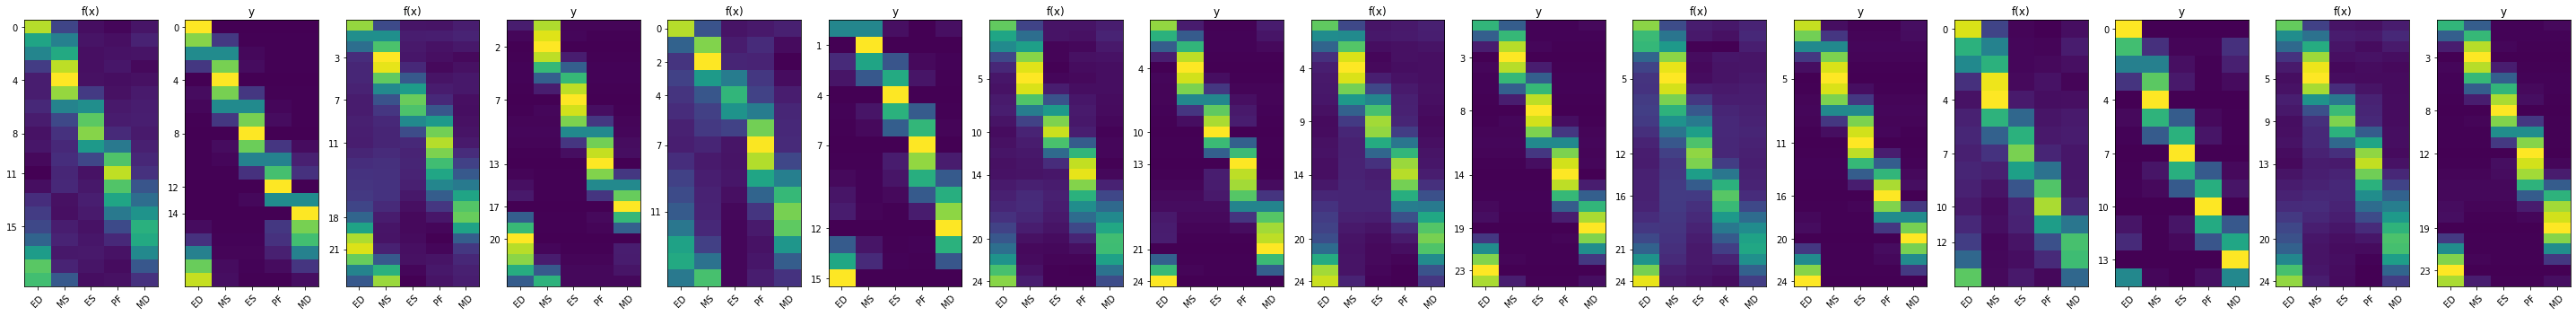

In [12]:
from src.visualization.Visualize import show_phases
_ = show_phases(outputs,pred)

In [20]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

NameError: name 'pred' is not defined

(8, 36, 5)
(5, 36, 8)


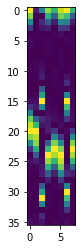

In [13]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

In [20]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=8.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.8>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.6>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.8>]

In [21]:
tf.reduce_mean(scores).numpy()

8.625

# Generator tests

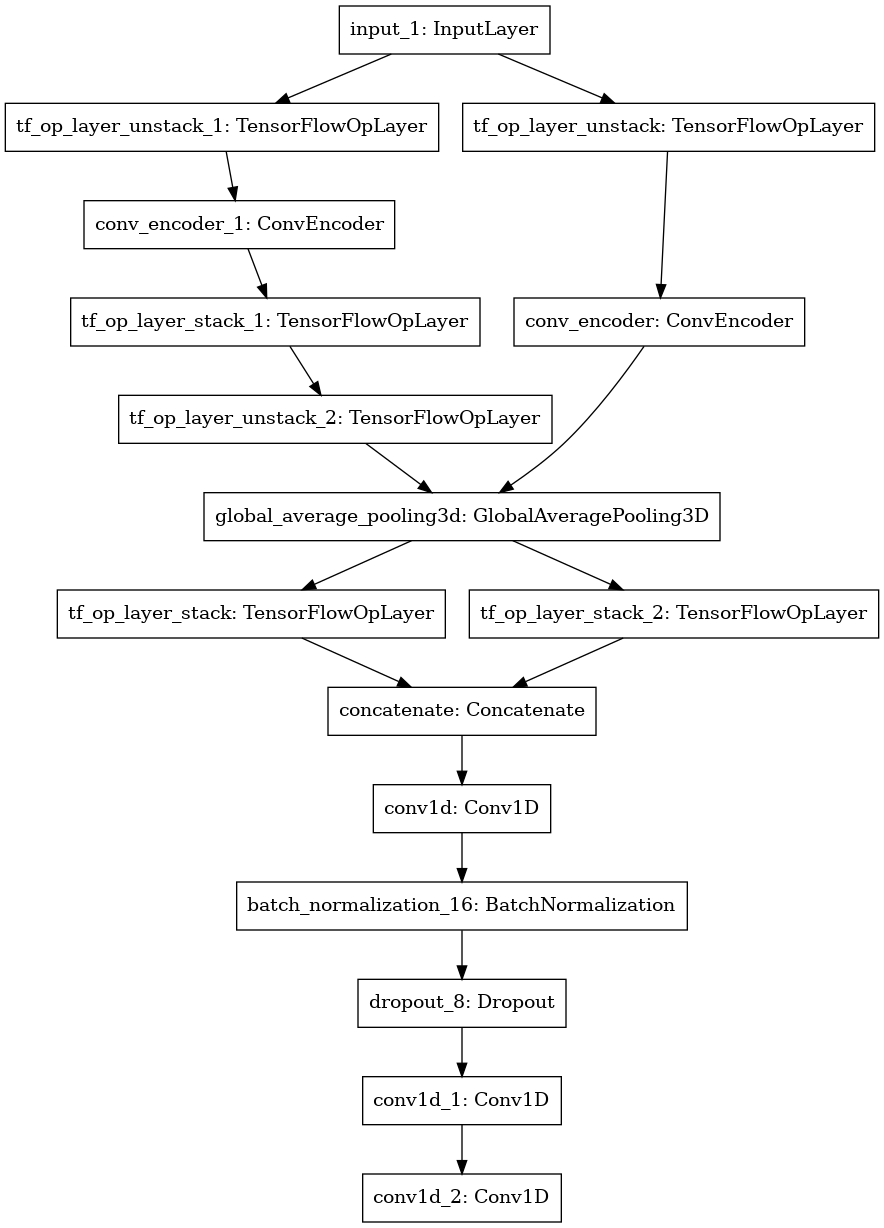

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [18]:
def meandiff_( y_true, y_pred, batchsize=4):

    """
    Average over the batches
    the sum of the absolute difference between two arrays
    y_true and y_pred are one-hot vectors with the following shape
    batchsize * timesteps * phase classes
    e.g.: 4 * 36 * 5
    First for gt and pred:
    - get the timesteps per phase with the highest probability
    - get the absolute difference between gt and pred
    (- later we can slice each patient by the max value in the corresponding gt indices)
    - sum the diff per entity
    - calc the mean over all examples

    Parameters
    ----------
    y_true :
    y_pred :

    Returns tf.float32 scalar
    -------

    """

    score = 0
    y_true = tf.cast(tf.convert_to_tensor(y_true), tf.float32)
    y_pred = tf.cast(tf.convert_to_tensor(y_pred), tf.float32)

    gt_idxs = tf.math.argmax(y_true, axis=1)
    gt_max = tf.cast(tf.reduce_max(gt_idxs, axis=1), tf.int32)
    padded_pred = []
    padded_gt = []

    msk = tf.stack([
        tf.pad(tf.ones((gt_max[i],5)), ((0,36-gt_max[i]),(0,0)))
        for i in range(batchsize)])
    #msk = tf.zeros_like(y_pred)
    #msk[:,:tf.reduce_max(gt_max), :] = 1

    temp_pred = y_pred * msk
    temp_gt = y_true * msk

    #y_pred = tf.unstack(y_pred, axis=0)
    #y_true = tf.unstack(y_true, axis=0)

    """def pad_to_size(p, max_id):
        to_pad = p.shape[0] - max_id
        print(p.shape[0])
        print(max_id)
        print(to_pad)
        return tf.pad(p, [[0,to_pad],[0,0]])

    padded_pred = list(map(lambda x : pad_to_size(x[0], x[1]), zip(y_pred, gt_max)))
    padded_gt = list(map(lambda x: pad_to_size(x[0], x[1]), zip(y_true, gt_max)))"""

    """for idx in tf.range(y_pred.shape[0]):
        max_idx = gt_max[idx]
        p = y_pred[idx][:max_idx, :]
        to_pad = y_pred.shape[1] - max_idx
        padded_pred.append(tf.pad(p, [[0,to_pad],[0,0]]))

        y = y_true[idx][:max_idx, :]
        padded_gt.append(tf.pad(y, [[0, to_pad], [0, 0]]))"""

    #temp_pred = tf.stack(padded_pred, axis=0)
    #temp_gt = tf.stack(padded_gt, axis=0)

    gt_idx = tf.math.argmax(temp_gt, axis=1)
    pred_idx = tf.math.argmax(temp_pred, axis=1)

    diffs = tf.stack([tf.stack(get_min_dist_for_list(gt_idx[i],pred_idx[i], batchsize)) for i in range(batchsize)])

    #diffs = tf.math.subtract(gt_idx, pred_idx)
    #print('substract: {}'.format(diffs.numpy()))
    #diffs = tf.abs(diffs)
    #print('abs: {}'.format(diffs.numpy()))
    diffs = tf.cast(tf.reduce_sum(diffs, axis=1),tf.float32)
    #print('sum: {}'.format(diffs.numpy()))
    diffs = tf.reduce_mean(diffs)

    return diffs


def get_min_dist_for_list(lst_a,lst_b, batchsize):
    length = tf.reduce_max(tf.stack([lst_a, lst_b]))
    #print(length)
    #length = max(max(lst_a), max(lst_b)) + 1
    return [get_min_distance(lst_a[i],lst_b[i],length) for i in range(batchsize)]

def get_min_distance(a, b, mod):
    #assert(mod>(tf.reduce_max(a,b))), 'a: {}, b: {}, mod:{}, '.format(a,b,mod)

    decr_counter = 0
    incr_counter = 0

    smaller = tf.reduce_min(tf.stack([a, b]))
    bigger = tf.reduce_max(tf.stack([a, b]))

    i1 = bigger
    while (i1 != smaller):
        decr_counter = decr_counter + 1
        i1 = i1 - 1

    i1 = bigger
    while (i1 != smaller):
        incr_counter = incr_counter + 1
        i1 = tf.math.mod((i1 + 1), mod)
        #i1 =  % mod

    return tf.reduce_min(tf.stack([decr_counter, incr_counter]))

In [22]:
lst = [1,2,3,4,5,6,7,8,9]
first = lst[3:]
first.extend(lst[:3])
first

[4, 5, 6, 7, 8, 9, 1, 2, 3]

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)